In [3]:
from truthnet import truthnet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
from tqdm.notebook import tqdm
import tikzplotlib as tpl
from datetime import datetime
from IPython.display import display, HTML
import glob
from zedstat import zedstat

from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import (
    ExtraTreesClassifier,
    RandomForestClassifier,
)
from sklearn.metrics import (
    PrecisionRecallDisplay,
    RocCurveDisplay,
    auc,
    mean_squared_error,
    precision_recall_curve,
    r2_score,
    roc_curve,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
import optuna

# optuna.logging.set_verbosity(optuna.logging.WARNING)

# Methods

In [30]:
from quasinet.qsampling import qsample
from scipy.stats import entropy
import random
from quasinet.utils import sample_from_dict


def _get_qnet(df):
    from quasinet import qnet

    qn = qnet.Qnet(
        feature_names=df.columns.values,
        min_samples_split=2,
        alpha=0.05,
        max_depth=-1,
        max_feats=-1,
        early_stopping=False,
        verbose=0,
        random_state=None,
        n_jobs=-1,
    )

    qn.fit(df.to_numpy(dtype="<U21"))

    return qn


def _get_tnets(
    df,
    df_pos=None,
    df_neg=None,
    diss_file=None,
):
    if df_pos is not None and df_neg is not None:
        non_null_cols = (
            (df.isna().sum() < len(df))
            & (df_pos.isna().sum() < len(df_pos))
            & (df_neg.isna().sum() < len(df_neg))
        )
        Tr = _get_qnet(df.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, ""))
        Tr_pos = _get_qnet(
            df_pos.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, "")
        )
        Tr_neg = _get_qnet(
            df_neg.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, "")
        )
    else:
        Tr = truthnet()
        length = sum(df.isna().sum() < len(df))
        df.fillna(-9).astype(int).replace(-9, "").to_csv("tmpfile.csv", index=False)
        features, samples = Tr.load_data(datapath="tmpfile.csv")
        Tr.fit(modelpath="tmp_Qnet.joblib")
        if diss_file is not None:
            Tr.dissonance = pd.read_csv(diss_file)
        else:
            Tr.getDissonance(outfile="data/tmp_dissonance_matrix.csv")
        coresamples = Tr.getCoresamples(alpha=0.01, steps=length)
        if len(coresamples) == len(df):
            mean_dissonance = pd.DataFrame(
                data=Tr.dissonance.mean(axis=1), columns=["mean_dissonance"]
            )
            coresamples = mean_dissonance.query(
                "mean_dissonance < mean_dissonance.quantile(0.99)"
            )
        df_pos = df.loc[coresamples.index.values]
        df_neg = df.loc[~df.index.isin(coresamples.index.values)]

        non_null_cols = (
            (df.isna().sum() < len(df))
            & (df_pos.isna().sum() < len(df_pos))
            & (df_neg.isna().sum() < len(df_neg))
        )

        Tr = _get_qnet(df.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, ""))
        Tr_neg = _get_qnet(
            df_neg.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, "")
        )
        Tr_pos = _get_qnet(
            df_pos.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, "")
        )

    return {
        "all": Tr,
        "pos": Tr_pos,
        "neg": Tr_neg,
        "data": df.loc[:, non_null_cols].fillna(-9).astype(int).replace(-9, ""),
    }


def _diss_linear(s, qnet):
    diss = list()
    Ds = qnet.predict_distributions(s)

    for i in range(len(s)):
        if s[i] != "":
            if s[i] in Ds[i].keys():
                diss.append(1 - Ds[i][s[i]] / np.max(list(Ds[i].values())))
            else:
                diss.append(1)

    return np.array(diss)


def _diss_log(s, qnet):
    diss = list()
    Ds = qnet.predict_distributions(s)

    for i in range(len(s)):
        if s[i] != "":
            if s[i] in Ds[i].keys():
                diss.append(-np.log(Ds[i][s[i]]))
            else:
                diss.append(np.inf)

    return np.array(diss)


def _actual_sample_dissonance(data_sample, diss_models, diss_fcn, order, length):
    if order is None:
        order = range(length)

    sample = np.full(length, "")

    diss = [list() for model in diss_models]

    for i in order:
        sample[i] = data_sample[i]
        [d.append(diss_fcn(sample, model)) for d, model in zip(diss, diss_models)]

    return sample, diss


def _all_actual_samples_dissonance(data_samples, diss_models, diss_fcn, order, length):
    samples = list()
    dissonances = list()

    for data_sample in tqdm(data_samples):
        samp, diss = _actual_sample_dissonance(
            data_sample, diss_models, diss_fcn, order, length
        )
        samples.append(samp)
        dissonances.append(diss)

    return samples, dissonances


def _sample_with_dissonance(
    sample_model,
    length,
    diss_models,
    diss_fcn=_diss_linear,
    order=None,
    data_samples=None,
):
    if order is None:
        order = range(length)

    if data_samples is not None:
        data_samples_df = pd.DataFrame(data_samples)
        data_sample_values = pd.Series(
            {
                col: [x for x in data_samples_df[col].unique() if x != ""]
                for col in data_samples_df
            }
        )

    sample = np.full(length, "")

    diss = [list() for model in diss_models]

    for i in order:
        if sample_model is not None:
            prob_dict = sample_model.predict_distribution(sample, i)
            sample[i] = sample_from_dict(prob_dict)
        else:
            sample[i] = random.choice(data_sample_values[i])
        [d.append(diss_fcn(sample, model)) for d, model in zip(diss, diss_models)]

    return sample, diss


def _nsamples_with_dissonance(
    n_samples,
    sample_model,
    length,
    diss_models,
    diss_fcn=_diss_linear,
    order=None,
    data_samples=None,
):
    samples = list()
    dissonances = list()

    for i in tqdm(range(n_samples)):
        samp, diss = _sample_with_dissonance(
            sample_model,
            length,
            diss_models,
            diss_fcn,
            order,
            data_samples,
        )
        samples.append(samp)
        dissonances.append(diss)

    return samples, dissonances


def _dissonance_data_at_question(dissonances, questions_asked):
    return np.array(
        [np.hstack([d[questions_asked - 1] for d in diss]) for diss in dissonances]
    )


# generate samples under the given models and compute dissonances under specified diss_models
def _sampling_scenario(
    n_qsamples,
    qsample_model,
    n_m2_samples,
    m2_model,
    diss_models,
    length,
    n_runif_samples=None,
    diss_fcn=_diss_linear,
    order=None,
    data_samples=None,
):
    samples = {}
    dissonances = {}

    if order == "entropy":
        Ds = qsample_model.predict_distributions(np.full(length, ""))
        entrpy = list()
        for i in range(len(Ds)):
            entrpy.append(entropy(np.fromiter(Ds[i].values(), dtype=float)))
        order = pd.Series(entrpy).sort_values().index

    if order == "random":
        order = list(range(length))
        random.shuffle(order)

    samples["qsampled"], dissonances["qsampled"] = _nsamples_with_dissonance(
        n_qsamples, qsample_model, length, diss_models, diss_fcn, order
    )

    samples["m2"], dissonances["m2"] = _nsamples_with_dissonance(
        n_m2_samples, m2_model, length, diss_models, diss_fcn, order
    )

    if n_runif_samples is not None:
        samples["runif"], dissonances["runif"] = _nsamples_with_dissonance(
            n_runif_samples,
            None,
            length,
            diss_models,
            diss_fcn,
            order,
            data_samples,
        )

    if data_samples is not None:
        dissonances["actual"] = _all_actual_samples_dissonance(
            data_samples, diss_models, diss_fcn, order, length
        )

    return samples, dissonances


def _diss_dataset(dissonances, questions_asked, groups=["qsampled", "m2"]):
    diss_dataset = pd.concat(
        [
            pd.DataFrame(
                _dissonance_data_at_question(dissonances[group], questions_asked)
            ).assign(y=group)
            for group in groups
        ]
    )
    return diss_dataset


def _save_sampling_scenarios(
    iter,
    name,
    df,
    n_qsamples,
    n_m2_samples,
    df_pos=None,
    df_neg=None,
    diss_file=None,
    diss_fcn=_diss_linear,
    order=None,
    n_runif_samples=None,
    invert_pos=False,
):
    for i in tqdm(iter):
        tn = _get_tnets(
            df=df,
            df_pos=df_pos,
            df_neg=df_neg,
            diss_file=diss_file,
        )

        data_samples = tn["data"]
        full_model = tn["all"]
        if invert_pos is True:
            pos_model = tn["neg"]
            neg_model = tn["pos"]
        else:
            pos_model = tn["pos"]
            neg_model = tn["neg"]

        length = len(full_model.feature_names)

        diss_models = [full_model, neg_model, pos_model]

        s, d = _sampling_scenario(
            n_qsamples,
            full_model,
            n_m2_samples,
            pos_model,
            diss_models,
            length,
            n_runif_samples,
            diss_fcn,
            order,
            data_samples=data_samples,
        )

        pd.to_pickle(s, f"{name}_{order}_order_samples_{i}.pkl")
        pd.to_pickle(d, f"{name}_{order}_order_disson_{i}.pkl")

In [7]:
Tr = truthnet()
features, samples = Tr.load_data(datapath="data/ptsd/PTSD_cognet_test_processed.csv")
Tr.fit(modelpath="tmp_Qnet.joblib")

Tr_pos = truthnet()
feat_pos, samp_pos = Tr_pos.load_data(
    datapath="data/ptsd/PTSD_cognet_test_processed_pos_only.csv"
)
Tr_pos.fit(modelpath="tmp_Qnet_pos.joblib")

Tr_neg = truthnet()
feat_neg, samp_neg = Tr_neg.load_data(
    datapath="data/ptsd/PTSD_cognet_test_processed_neg_only.csv"
)
Tr_neg.fit(modelpath="tmp_Qnet_neg.joblib")

In [24]:
full_model = Tr.model_obj.myQnet
pos_model = Tr_pos.model_obj.myQnet
neg_model = Tr_neg.model_obj.myQnet

diss_models = [full_model, neg_model, pos_model]
ds = pd.read_csv("data/ptsd/PTSD_cognet_test_processed.csv").head(5).to_numpy()

In [25]:
d = _all_actual_samples_dissonance(ds, diss_models, _diss_linear, None, 211)

  0%|          | 0/5 [00:00<?, ?it/s]

In [28]:
ds

array([[4, 2, 5, ..., 2, 4, 2],
       [3, 2, 3, ..., 3, 4, 5],
       [2, 2, 2, ..., 2, 2, 5],
       [2, 2, 5, ..., 1, 2, 2],
       [4, 1, 1, ..., 2, 2, 3]])

In [ ]:
d[1]

# PTSD

In [ ]:
_save_sampling_scenarios(
    iter=range(10),
    df=pd.read_csv("data/ptsd/PTSD_cognet_test_processed.csv"),
    name="disson_ptsd/core/disson_ptsd_core",
    diss_file=None,
    n_qsamples=100,
    n_m2_samples=100,
    order="random",
    n_runif_samples=100,
    invert_pos=False,
)

Non-core sampling for m2, with actual dissonances added:

In [ ]:
_save_sampling_scenarios(
    iter=range(1),
    df=pd.read_csv("data/ptsd/PTSD_cognet_test_processed.csv"),
    df_pos=pd.read_csv("data/ptsd/PTSD_cognet_test_processed_pos_only.csv"),
    df_neg=pd.read_csv("data/ptsd/PTSD_cognet_test_processed_neg_only.csv"),
    name="disson_ptsd/disson_ptsd_qmra",
    diss_file=None,
    n_qsamples=100,
    n_m2_samples=100,
    order="random",
    n_runif_samples=100,
    invert_pos=False,
)

In [9]:
diss = [
    pd.read_pickle(d)
    for d in glob.glob("disson_ptsd/core/disson_ptsd_core_random_order_disson*.pkl")
]

samps = [
    pd.read_pickle(d)
    for d in glob.glob("disson_ptsd/core/disson_ptsd_core_random_order_samples*.pkl")
]

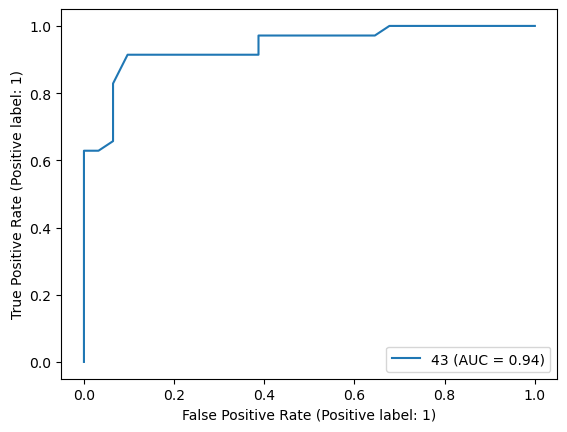

In [10]:
groups = ["qsampled", "runif"]

questions_asked = 43
data = _diss_dataset(diss[0], questions_asked, groups=groups)
X_train, X_test, y_train, y_test = train_test_split(
    data.drop("y", axis="columns"), data["y"], test_size=0.33
)

fig, ax = plt.subplots()

classifier = RandomForestClassifier(n_jobs=-1)

classifier.fit(
    X_train.to_numpy(),
    y_train.replace(
        {
            groups[0]: 0,
            groups[1]: 1,
        }
    ),
)

r = RocCurveDisplay.from_estimator(
    classifier,
    X_test.to_numpy(),
    y_test.replace(
        {
            groups[0]: 0,
            groups[1]: 1,
        }
    ),
    pos_label=1,
    ax=ax,
    name=questions_asked,
)

In [ ]:
groups = ["qsampled", "m2"]
output_path = "data/classification/ptsd/core/"
name = f"rf_{groups[1]}_core_random_order"

auc_dfs = list()
plot = False
retrains = 3
n_trials = 50
question_iter = range(1, 102, 5)

classifier = RandomForestClassifier(n_jobs=-1)
# classifier = lgb.LGBMClassifier()


# for each dissonance file
for d in tqdm(diss, desc="Dissonance files"):
    # repeat performance calc
    for _ in tqdm(range(retrains), desc="Training cycles this file"):
        fig, ax = plt.subplots()
        aucs = list()
        z_aucs = list()
        z_aucs_lb = list()
        z_aucs_ub = list()
        roc_dfs = list()

        # which computes the auc for classifier at each question marker
        for questions_asked in question_iter:
            data = _diss_dataset(d, questions_asked, groups=groups)
            X_train, X_test, y_train, y_test = train_test_split(
                data.drop("y", axis="columns"), data["y"], test_size=0.33
            )

            # X_train = X_train.mean(axis=1)
            # X_test = X_test.mean(axis=1)

            def objective(trial):
                # pruning_callback = optuna.integration.LightGBMPruningCallback(
                #    trial, "auc"
                # )

                param = {
                    "n_estimators": trial.suggest_int("n_estimators", 50, 250),
                    "max_depth": trial.suggest_int("max_depth", 5, 15),
                    "min_samples_split": trial.suggest_int("min_samples_split", 10, 30),
                }

                classifier.set_params(**param)
                classifier.fit(
                    X_train.to_numpy(),
                    y_train.replace(
                        {
                            groups[0]: 0,
                            groups[1]: 1,
                        }
                    ),
                    # callbacks=[pruning_callback],
                )

                r = RocCurveDisplay.from_estimator(
                    classifier,
                    X_test.to_numpy(),
                    y_test.replace(
                        {
                            groups[0]: 0,
                            groups[1]: 1,
                        }
                    ),
                    pos_label=1,
                    ax=ax,
                    name=questions_asked,
                )

                return r.roc_auc

            study = optuna.create_study(
                # pruner=optuna.pruners.MedianPruner(n_warmup_steps=10),
                direction="maximize",
            )
            func = lambda trial: objective(trial, param)
            study.optimize(objective, n_trials=n_trials)

            classifier.set_params(**study.best_trial.params)
            classifier.fit(
                X_train.to_numpy(),
                y_train.replace(
                    {
                        groups[0]: 0,
                        groups[1]: 1,
                    }
                ),
            )

            r = RocCurveDisplay.from_estimator(
                classifier,
                X_test.to_numpy(),
                y_test.replace(
                    {
                        groups[0]: 0,
                        groups[1]: 1,
                    }
                ),
                pos_label=1,
                ax=ax,
                name=questions_asked,
            )
            aucs.append(r.roc_auc)
            fpr, tpr, thresholds = roc_curve(
                y_test.replace(
                    {
                        groups[0]: 0,
                        groups[1]: 1,
                    }
                ),
                classifier.predict_proba(X_test.to_numpy())[:, 1],
                pos_label=1,
            )
            roc_df = pd.DataFrame({"fpr": fpr, "tpr": tpr, "threshold": thresholds})
            roc_dfs.append(roc_df.assign(questions=questions_asked))
            if plot is False:
                plt.close()

            try:
                zt = zedstat.processRoc(
                    roc_df,
                    order=3,
                    total_samples=1000,
                    positive_samples=150,
                    alpha=0.01,
                    prevalence=0.15,
                )

                zt.smooth(STEP=0.01)
                zt.allmeasures(interpolate=False)
                zt.usample(precision=3)
                zt.getBounds()
                z_aucs.append(zt.auc()[0])
                z_aucs_lb.append(zt.auc()[2])
                z_aucs_ub.append(zt.auc()[1])
            except:
                z_aucs.append(r.roc_auc)
                z_aucs_lb.append(r.roc_auc)
                z_aucs_ub.append(r.roc_auc)

        auc_df = pd.DataFrame(
            {
                "questions asked": question_iter,
                "auc": aucs,
                "z_auc": z_aucs,
                "z_auc_lb": z_aucs_lb,
                "z_auc_ub": z_aucs_ub,
            }
        )

        if plot is True:
            ax = auc_df.plot(x="questions asked", y="z_auc")
            ax.fill_between(
                auc_df["questions asked"],
                auc_df["z_auc_ub"],
                auc_df["z_auc_lb"],
                alpha=0.25,
            )

        time = str(datetime.now())

        pd.concat(roc_dfs).to_csv(
            f"{output_path}roc_df_rf_{name}_{time}.csv",
            index=False,
        )
        auc_dfs.append(auc_df)
        auc_df.to_csv(
            f"{output_path}auc_df_rf_{name}_{time}.csv",
            index=False,
        )
    pd.concat(auc_dfs).groupby(level=0).mean().to_csv(
        f"{output_path}auc_dfs_rf_{name}_{datetime.now()}.csv",
        index=False,
    )

In [12]:
conf = 0.95

rf_res = pd.concat(
    [pd.read_csv(df) for df in glob.glob(f"{output_path}auc_df_rf_{name}_*.csv")]
)

rf_auc_ci_var = rf_res.groupby(["questions asked"], as_index=False).agg(
    mean=pd.NamedAgg(column="auc", aggfunc="mean"),
    var=pd.NamedAgg(column="auc", aggfunc="var"),
    ci=pd.NamedAgg(
        column="auc",
        aggfunc=lambda x: sms.DescrStatsW(x).tconfint_mean(alpha=1 - conf),
    ),
)

rf_auc_ci_var.assign(
    lower=lambda x: [c[0] for c in x["ci"]], upper=lambda x: [c[1] for c in x["ci"]]
).drop("ci", axis="columns")

,questions asked,mean,var,lower,upper
0,1,0.628619,0.004293,0.604153,0.653084
1,6,0.831197,0.002566,0.812280,0.850113
2,11,0.881533,0.001724,0.866031,0.897036
3,16,0.902004,0.001323,0.888423,0.915585
4,21,0.933901,0.000991,0.922149,0.945653
5,26,0.953393,0.000447,0.945500,0.961286
6,31,0.962656,0.000348,0.955687,0.969626
7,36,0.961663,0.000344,0.954742,0.968583
8,41,0.972189,0.000384,0.964870,0.979509
9,46,0.978810,0.000384,0.971495,0.986125


In [13]:
results_path = "data/classification/ptsd/core/results/"

rf_auc_ci_var.assign(
    lower=lambda x: [c[0] for c in x["ci"]], upper=lambda x: [c[1] for c in x["ci"]]
).drop("ci", axis="columns").to_csv(f"{results_path}results_{name}.csv", index=False)

In [14]:
groups = ["qsampled", "m2"]
output_path = "data/classification/ptsd/core/"
name = f"rf_{groups[1]}_core_random_order"
results_path = "data/classification/ptsd/core/results/"

df = pd.read_csv(f"{results_path}results_{name}.csv")

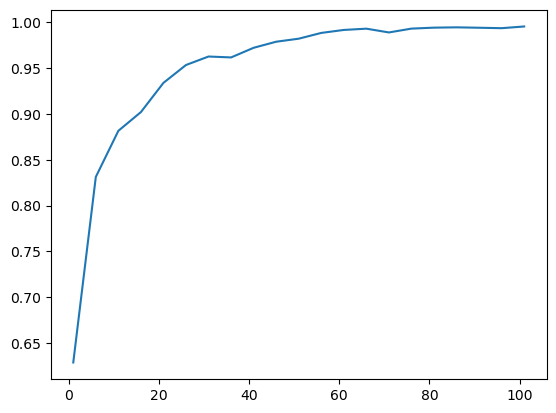

In [15]:
plt.plot(df["questions asked"], df["mean"])

# Global

In [7]:
_save_sampling_scenarios(
    iter=range(1, 10),
    df=pd.read_csv("data/gibbons_global/gibbons_global.csv"),
    name="disson_global/core/disson_global_core",
    diss_file=None,
    n_qsamples=100,
    n_m2_samples=100,
    order="random",
    n_runif_samples=100,
    invert_pos=False,
)

  0%|          | 0/9 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1236 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1236 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1236 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1236 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1236 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1236 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1236 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1236 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1236 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1236 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1236 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1236 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1236 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1236 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1236 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1236 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1236 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1236 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1236 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1236 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1236 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1236 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1236 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1236 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/1236 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1236 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1236 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [6]:
groups = ["qsampled", "runif"]
questions_asked = 43
data = _diss_dataset(d, questions_asked, groups=groups)
X_train, X_test, y_train, y_test = train_test_split(
    data.drop("y", axis="columns"), data["y"], test_size=0.33
)
data

,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,128,y
0,0.000000,0.000000,0.000000,0.416086,0.242870,0.000000,0.000000,0.065574,0.666667,0.007729,...,0.00,0.192308,0.636364,0.000000,0.488889,0.599265,0.166667,0.000000,0.555556,qsampled
1,0.000000,0.000000,0.000000,0.000000,0.776521,0.000000,0.000000,0.065574,0.666667,0.510219,...,0.00,0.192308,0.068182,1.000000,0.000000,0.000000,0.166667,0.000000,0.000000,qsampled
2,0.000000,0.514286,0.833333,0.950324,0.000000,0.000000,0.000000,0.000000,0.625000,0.031798,...,0.00,0.192308,0.545455,0.555085,0.911111,0.147059,0.000000,0.000000,0.000000,qsampled
3,0.000000,0.514286,0.000000,0.000000,0.776521,0.000000,0.000000,0.065574,0.888889,0.000000,...,0.25,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,qsampled
4,0.000000,0.514286,0.000000,0.000000,0.095405,0.000000,0.000000,0.000000,0.500000,0.018209,...,0.00,0.000000,0.068182,0.000000,0.488889,0.121324,0.166667,0.883721,1.000000,qsampled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.897436,0.000000,0.833333,0.000000,0.000000,0.948718,0.000000,0.000000,0.888889,0.802676,...,0.25,0.192308,0.000000,1.000000,0.844444,0.183824,0.666667,0.000000,1.000000,runif
96,0.000000,0.514286,0.833333,0.000000,0.770269,0.000000,0.930657,0.065574,0.666667,0.018209,...,0.00,0.192308,0.000000,1.000000,0.750000,0.000000,0.166667,0.606383,1.000000,runif
97,0.000000,0.000000,0.000000,0.000000,0.772460,0.948718,0.937500,0.770492,0.888889,0.000000,...,0.25,0.192308,0.590909,0.000000,1.000000,0.000000,0.333333,0.000000,1.000000,runif
98,0.000000,0.514286,0.000000,0.794549,0.785826,0.948718,0.000000,0.836066,0.666667,0.457451,...,0.25,0.000000,0.590909,1.000000,0.250000,0.000000,0.666667,1.000000,0.000000,runif


In [52]:
df = pd.read_csv("data/gibbons_global/gibbons_global.csv")
tn = _get_tnets(df=df, diss_file="data/tmp_dissonance_matrix.csv")

QUEUEING TASKS | :   0%|          | 0/1236 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1236 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1236 [00:00<?, ?it/s]

In [56]:
tn["neg"].feature_names

array(['2', '5', '6', '8', '9', '10', '11', '12', '13', '15', '16', '17',
       '18', '19', '20', '29', '30', '31', '33', '35', '36', '37', '39',
       '41', '44', '46', '50', '51', '52', '53', '54', '55', '56', '58',
       '61', '62', '63', '66', '67', '68', '69', '70', '71', '72', '75',
       '76', '82', '84', '85', '86', '90', '92', '93', '95', '100', '102',
       '106', '108', '109', '110', '111', '112', '114', '115', '116',
       '122', '123', '125', '135', '137', '139', '140', '147', '149',
       '150', '159', '165', '168', '179', '186', '191', '192', '197',
       '198', '210', '226', '238', '239', '244', '246', '248', '249',
       '251', '252', '264', '265', '292', '305', '308', '310', '312',
       '355', '358', '360', '361', '365', '366', '368', '394', '395',
       '397', '400', '401', '403', '418', '428', '436', '441', '442',
       '449', '491', '516', '572', '589', '590', '591', '603', '606',
       '719', '730', '731', '737', '740', '742', '747', '748', '753',
  

In [18]:
df = pd.read_csv("data/ptsd/PTSD_cognet_test_processed.csv")
Tr = truthnet()
length = sum(df.isna().sum() < len(df))
df.fillna(-9).astype(int).replace(-9, "").to_csv("tmpfile.csv", index=False)
features, samples = Tr.load_data(datapath="tmpfile.csv")
samples

array([['4', '2', '5', ..., '2', '4', '2'],
       ['3', '2', '3', ..., '3', '4', '5'],
       ['2', '2', '2', ..., '2', '2', '5'],
       ...,
       ['5', '1', '2', ..., '2', '5', '5'],
       ['2', '1', '3', ..., '2', '2', '2'],
       ['5', '2', '1', ..., '2', '1', '4']], dtype='<U21')

In [45]:
len(coresamples) < len(df)

False

In [47]:
df = pd.read_csv("data/gibbons_global/gibbons_global.csv")
Tr = truthnet()
length = sum(df.isna().sum() < len(df))
df.fillna(-9).astype(int).replace(-9, "").to_csv("tmpfile.csv", index=False)
features, samples = Tr.load_data(datapath="tmpfile.csv")
Tr.fit(modelpath="tmp_Qnet.joblib")

Tr.dissonance = pd.read_csv("data/tmp_dissonance_matrix.csv")
coresamples = Tr.getCoresamples(alpha=0.01, steps=length)
if len(coresamples) == len(df):
    mean_dissonance = pd.DataFrame(
        data=Tr.dissonance.mean(axis=1), columns=["mean_dissonance"]
    )
    coresamples = mean_dissonance.query(
        "mean_dissonance < mean_dissonance.quantile(0.99)"
    )
df_neg = df.loc[coresamples.index.values]
df_pos = df.loc[~df.index.isin(coresamples.index.values)]

non_null_cols = (
    (df.isna().sum() < len(df))
    & (df_pos.isna().sum() < len(df_pos))
    & (df_neg.isna().sum() < len(df_neg))
)

QUEUEING TASKS | :   0%|          | 0/1236 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1236 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1236 [00:00<?, ?it/s]

In [50]:
df_neg

,2,3,5,6,7,8,9,10,11,12,...,4592,4593,4594,4596,4631,4632,4634,4635,4636,4637
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1231,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN
1232,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
1233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN
1234,NaN,NaN,2.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,NaN


In [49]:
df_pos

,2,3,5,6,7,8,9,10,11,12,...,4592,4593,4594,4596,4631,4632,4634,4635,4636,4637
131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN
151,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN
221,NaN,NaN,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,...,NaN,NaN,1.0,2.0,NaN,1.0,1.0,NaN,NaN,NaN
433,NaN,NaN,1.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,NaN
488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,5.0,5.0,5.0,4.0,NaN,5.0,5.0,NaN,NaN
557,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
597,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN
616,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
630,NaN,NaN,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
797,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
mean_dissonance.query("mean_dissonance < mean_dissonance.quantile(0.99)")

,mean_dissonance
0,0.081713
1,0.100173
2,0.084652
3,0.098421
4,0.112000
...,...
1231,0.102596
1232,0.100542
1233,0.084890
1234,0.111382


In [34]:
coresamples.index.values

array([   0,    1,    2, ..., 1233, 1234, 1235])

In [35]:
df

,2,3,5,6,7,8,9,10,11,12,...,4592,4593,4594,4596,4631,4632,4634,4635,4636,4637
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1231,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN
1232,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
1233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN
1234,NaN,NaN,2.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,NaN


In [27]:
non_null_cols

2       False
3       False
5       False
6       False
7       False
        ...  
4632    False
4634    False
4635    False
4636    False
4637    False
Length: 424, dtype: bool

In [17]:
samples

array([['', '', '', ..., '', '', ''],
       ['', '', '', ..., '', '', ''],
       ['', '', '', ..., '', '', ''],
       ...,
       ['', '', '', ..., '', '', ''],
       ['', '', '2', ..., '', '2', ''],
       ['', '', '', ..., '', '1', '']], dtype='<U1')

In [6]:
diss = [
    pd.read_pickle(d)
    for d in glob.glob("disson_global/core/disson_global_core_random_order_disson*.pkl")
]

samps = [
    pd.read_pickle(d)
    for d in glob.glob(
        "disson_global/core/disson_global_core_random_order_samples*.pkl"
    )
]

In [8]:
diss

[{'qsampled': [[[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
   [[], [], []],
  

In [7]:
groups = ["qsampled", "runif"]

questions_asked = 43
data = _diss_dataset(diss[0], questions_asked, groups=groups)
X_train, X_test, y_train, y_test = train_test_split(
    data.drop("y", axis="columns"), data["y"], test_size=0.33
)

fig, ax = plt.subplots()

classifier = RandomForestClassifier(n_jobs=-1)

classifier.fit(
    X_train.to_numpy(),
    y_train.replace(
        {
            groups[0]: 0,
            groups[1]: 1,
        }
    ),
)

r = RocCurveDisplay.from_estimator(
    classifier,
    X_test.to_numpy(),
    y_test.replace(
        {
            groups[0]: 0,
            groups[1]: 1,
        }
    ),
    pos_label=1,
    ax=ax,
    name=questions_asked,
)

IndexError: list index out of range

In [ ]:
groups = ["qsampled", "m2"]
output_path = "data/classification/global/core/"
name = f"rf_{groups[1]}_core_random_order"

auc_dfs = list()
plot = False
retrains = 3
n_trials = 50
question_iter = range(1, 102, 5)

classifier = RandomForestClassifier(n_jobs=-1)
# classifier = lgb.LGBMClassifier()


# for each dissonance file
for d in tqdm(diss, desc="Dissonance files"):
    # repeat performance calc
    for _ in tqdm(range(retrains), desc="Training cycles this file"):
        fig, ax = plt.subplots()
        aucs = list()
        z_aucs = list()
        z_aucs_lb = list()
        z_aucs_ub = list()
        roc_dfs = list()

        # which computes the auc for classifier at each question marker
        for questions_asked in question_iter:
            data = _diss_dataset(d, questions_asked, groups=groups)
            X_train, X_test, y_train, y_test = train_test_split(
                data.drop("y", axis="columns"), data["y"], test_size=0.33
            )

            # X_train = X_train.mean(axis=1)
            # X_test = X_test.mean(axis=1)

            def objective(trial):
                # pruning_callback = optuna.integration.LightGBMPruningCallback(
                #    trial, "auc"
                # )

                param = {
                    "n_estimators": trial.suggest_int("n_estimators", 50, 250),
                    "max_depth": trial.suggest_int("max_depth", 5, 15),
                    "min_samples_split": trial.suggest_int("min_samples_split", 10, 30),
                }

                classifier.set_params(**param)
                classifier.fit(
                    X_train.to_numpy(),
                    y_train.replace(
                        {
                            groups[0]: 0,
                            groups[1]: 1,
                        }
                    ),
                    # callbacks=[pruning_callback],
                )

                r = RocCurveDisplay.from_estimator(
                    classifier,
                    X_test.to_numpy(),
                    y_test.replace(
                        {
                            groups[0]: 0,
                            groups[1]: 1,
                        }
                    ),
                    pos_label=1,
                    ax=ax,
                    name=questions_asked,
                )

                return r.roc_auc

            study = optuna.create_study(
                # pruner=optuna.pruners.MedianPruner(n_warmup_steps=10),
                direction="maximize",
            )
            func = lambda trial: objective(trial, param)
            study.optimize(objective, n_trials=n_trials)

            classifier.set_params(**study.best_trial.params)
            classifier.fit(
                X_train.to_numpy(),
                y_train.replace(
                    {
                        groups[0]: 0,
                        groups[1]: 1,
                    }
                ),
            )

            r = RocCurveDisplay.from_estimator(
                classifier,
                X_test.to_numpy(),
                y_test.replace(
                    {
                        groups[0]: 0,
                        groups[1]: 1,
                    }
                ),
                pos_label=1,
                ax=ax,
                name=questions_asked,
            )
            aucs.append(r.roc_auc)
            fpr, tpr, thresholds = roc_curve(
                y_test.replace(
                    {
                        groups[0]: 0,
                        groups[1]: 1,
                    }
                ),
                classifier.predict_proba(X_test.to_numpy())[:, 1],
                pos_label=1,
            )
            roc_df = pd.DataFrame({"fpr": fpr, "tpr": tpr, "threshold": thresholds})
            roc_dfs.append(roc_df.assign(questions=questions_asked))
            if plot is False:
                plt.close()

            try:
                zt = zedstat.processRoc(
                    roc_df,
                    order=3,
                    total_samples=1000,
                    positive_samples=150,
                    alpha=0.01,
                    prevalence=0.15,
                )

                zt.smooth(STEP=0.01)
                zt.allmeasures(interpolate=False)
                zt.usample(precision=3)
                zt.getBounds()
                z_aucs.append(zt.auc()[0])
                z_aucs_lb.append(zt.auc()[2])
                z_aucs_ub.append(zt.auc()[1])
            except:
                z_aucs.append(r.roc_auc)
                z_aucs_lb.append(r.roc_auc)
                z_aucs_ub.append(r.roc_auc)

        auc_df = pd.DataFrame(
            {
                "questions asked": question_iter,
                "auc": aucs,
                "z_auc": z_aucs,
                "z_auc_lb": z_aucs_lb,
                "z_auc_ub": z_aucs_ub,
            }
        )

        if plot is True:
            ax = auc_df.plot(x="questions asked", y="z_auc")
            ax.fill_between(
                auc_df["questions asked"],
                auc_df["z_auc_ub"],
                auc_df["z_auc_lb"],
                alpha=0.25,
            )

        time = str(datetime.now())

        pd.concat(roc_dfs).to_csv(
            f"{output_path}roc_df_rf_{name}_{time}.csv",
            index=False,
        )
        auc_dfs.append(auc_df)
        auc_df.to_csv(
            f"{output_path}auc_df_rf_{name}_{time}.csv",
            index=False,
        )
    pd.concat(auc_dfs).groupby(level=0).mean().to_csv(
        f"{output_path}auc_dfs_rf_{name}_{datetime.now()}.csv",
        index=False,
    )

In [ ]:
conf = 0.95

rf_res = pd.concat(
    [pd.read_csv(df) for df in glob.glob(f"{output_path}auc_df_rf_{name}_*.csv")]
)

rf_auc_ci_var = rf_res.groupby(["questions asked"], as_index=False).agg(
    mean=pd.NamedAgg(column="auc", aggfunc="mean"),
    var=pd.NamedAgg(column="auc", aggfunc="var"),
    ci=pd.NamedAgg(
        column="auc",
        aggfunc=lambda x: sms.DescrStatsW(x).tconfint_mean(alpha=1 - conf),
    ),
)

rf_auc_ci_var.assign(
    lower=lambda x: [c[0] for c in x["ci"]], upper=lambda x: [c[1] for c in x["ci"]]
).drop("ci", axis="columns")

In [ ]:
results_path = "data/classification/global/core/results/"

rf_auc_ci_var.assign(
    lower=lambda x: [c[0] for c in x["ci"]], upper=lambda x: [c[1] for c in x["ci"]]
).drop("ci", axis="columns").to_csv(f"{results_path}results_{name}.csv", index=False)

In [ ]:
groups = ["qsampled", "m2"]
output_path = "data/classification/ptsd/core/"
name = f"rf_{groups[1]}_core_random_order"
results_path = "data/classification/ptsd/core/results/"

df = pd.read_csv(f"{results_path}results_{name}.csv")

plt.plot(df["questions asked"], df["mean"])

In [17]:
pd.read_csv("data/ptsd/PTSD_cognet_test_processed.csv").fillna(-9).astype(int).replace(
    -9, ""
).iloc[:, 1]

0      2
1      2
2      2
3      2
4      1
      ..
299    2
300    2
301    1
302    1
303    2
Name: ptsd2, Length: 304, dtype: int64

In [22]:
pd.read_csv("data/gibbonsglobal.csv").iloc[:, 2:].iloc[:, 0]

0      -9
1      -9
2      -9
3      -9
4      -9
       ..
1231   -9
1232   -9
1233   -9
1234   -9
1235   -9
Name: 2, Length: 1236, dtype: int64